# Test the accuracy against BLAST on CataloDB

Here we have a low sequence homology set so we can really test how the model performs on low homology sequences.

The first step is to get the residues and test the two sets.



In [64]:
import pandas as pd
import os 
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk/')
from enzymetk.sequence_search_blast import BLAST
from enzymetk.save_step import Save
from sciutil import SciUtil
from Bio import SeqIO


u = SciUtil()

swissprot = pd.read_csv('data/wills_metadata.tsv', sep='\t')

def annotate_residue_from_uniprot(df):
    # Organise the active sites of these guys to be better
    active_sites = []
    active_site_residue_counts = []
    x = 0
    for act_site in df['Active site'].values:
        sites = []
        if isinstance(act_site, str):
            act_site = act_site.replace(" ", '')
            for act in act_site.split('ACT_SITE'):
                try:
                    sites.append(int(act.split(';')[0].replace(" ", '')) - 1) # Need to subtract 1 to make it fit with the fact that python is 0 encoded lol
                except:
                    x = 1
        if len(sites) != 0:
            active_sites.append('|'.join([str(s) for s in sites]))
            active_site_residue_counts.append(len(sites))
        else:
            active_sites.append('None')
            active_site_residue_counts.append(0)
    df['Residue'] = active_sites
    df['active_site_residue_counts'] = active_site_residue_counts
    return df
    
swissprot = annotate_residue_from_uniprot(swissprot)
swissprot = swissprot[swissprot['active_site_residue_counts'] > 0]
training_ids = set(pd.read_csv('data/Low30_mmseq_ID_exp_subset_train.csv')['Entry'].values)
test_ids = set(pd.read_csv('data/Low30_mmseq_ID_exp_subset_test_foldseek.csv')['Entry'].values)

u.dp(['Number of training set:', len(training_ids), '\nNumber of test set:', len(test_ids)])

# Filter to not include the ones that weren't in the test set
# Read in the fasta files
# Read a FASTA file
test_ids = []
for record in SeqIO.parse("data/fastas/test.fasta", "fasta"):
    test_ids.append(record.id.split('|')[1])

# After filtering for those in SwissProt
test_df = swissprot[swissprot['Entry'].isin(test_ids)]
training_df = swissprot[swissprot['Entry'].isin(training_ids)]

u.dp(['Number of training set:', len(training_df), '\nNumber of test set:', len(test_df)])

--------------------------------------------------------------------------------
             Number of training set:	5355	
Number of test set:	239	             
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
             Number of training set:	5355	
Number of test set:	232	             
--------------------------------------------------------------------------------


# Write these as a fasta and run BLAST on them to collect the nearest enzyme

Here we are inferring the sequences using BLAST to combine with Squidly.

In [65]:
# Save the training data as a database we're going to save this as a fasta file 
fasta_label = f'swissprot_with_active_site_seqs_SquidlyBenchmark.fasta'
with open(fasta_label, 'w+') as fout:
    for entry, seq in training_df[['Entry', 'Sequence']].values:
        if entry not in test_ids:
            fout.write(f'>{entry}\n{seq}\n')
        else:
            # Just making double sure no contamination
            print(f"{entry} in training set?")
    
# Do blast on this dataset 
# This should be where you downloaded the data from zotero, there is a folder in there called AS_inference
# This contains the models and the data needed to run the tool
id_col = 'Entry'
seq_col = 'Sequence'
blast_df = (test_df << (BLAST(id_col, seq_col, database=fasta_label, args=['--ultra-sensitive']) >> Save(f'data/blast/Squidly_BLAST_Low30_mmseq_ID_foldseek_subset.pkl')))

diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Database input file: swissprot_with_active_site_seqs_SquidlyBenchmark.fasta
Opening the database file...  [0.001s]
Loading sequences...  [0.008s]
Masking sequences...  [0.029s]
Writing sequences...  [0.001s]
Hashing sequences...  [0s]
Loading sequences...  [0s]
Writing trailer...  [0s]
Closing the input file...  [0s]
Closing the database file...  [0.002s]

Database sequences  5355
  Database letters  2195041
     Database hash  af5530a8efa5117c2130e2159a2377a9
        Total time  0.043000s


['diamond', 'blastp', '--ultra-sensitive', '-d', '/tmp/tmp37g7krsq/MWbOcJ2mSN_db', '-q', '/tmp/tmp37g7krsq/MWbOcJ2mSN_query.fasta', '-o', '/tmp/tmp37g7krsq/MWbOcJ2mSN_matches.tsv']
--------------------------------------------------------------------------------
Running command	diamond blastp --ultra-sensitive -d /tmp/tmp37g7krsq/MWbOcJ2mSN_db -q /tmp/tmp37g7krsq/MWbOcJ2mSN_query.fasta -o /tmp/tmp37g7krsq/MWbOcJ2mSN_matches.tsv	
--------------------------------------------------------------------------------


diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmp37g7krsq
#Target sequences to report alignments for: 25
Opening the database...  [0.002s]
Database: /tmp/tmp37g7krsq/MWbOcJ2mSN_db (type: Diamond database, sequences: 5355, letters: 2195041)
Block size = 400000000
Opening the input file...  [0s]
Opening the output file...  [0s]
Loading query sequences...  [0s]
Masking queries...  [0.021s]
Algorithm: Double-indexed
Building query histograms...  [0.107s]
Seeking in database...  [0s]
Loading reference sequences...  [0.002s]
Masking reference...  [0.023s]
Initializing temporary storage...  [0.001s]
Building reference histograms...  [0.112s]
Allocatin

--------------------------------------------------------------------------------
                                    Output:	                                    
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Error:	diamond v2.1.11.165 (C) Max Planck Society for the Advancement of Science, Benjamin Buchfink, University of Tuebingen
Documentation, support and updates available at http://www.diamondsearch.org
Please cite: http://dx.doi.org/10.1038/s41592-021-01101-x Nature Methods (2021)

#CPU threads: 384
Scoring parameters: (Matrix=BLOSUM62 Lambda=0.267 K=0.041 Penalties=11/1)
Temporary directory: /tmp/tmp37g7krsq
#Target sequences to report alignments for: 25
Opening the database...  [0.002s]
Database: /tmp/tmp37g7krsq/MWbOcJ2mSN_db (type: Diamond database, sequences: 5355, letters: 2195041)
Block size = 400000000
Opening the input file...  [0s]
Opening the output file..

# Clean the BLAST results to only keep the top one

Here we want to once we have a single enzyme, we want to align it to the most homologous sequence and then we can get the active site based on the annotation. To do this we align with clustalomega (you need this installed in order to do this!)
http://www.clustal.org/omega/


In [66]:
blast_df = blast_df.sort_values(by='sequence identity', ascending=False)
# Remove duplicates 
blast_df.drop_duplicates('query', inplace=True)

#Then join up with all df
blast_df.set_index('query', inplace=True)
test_df.set_index('Entry', inplace=True)
test_df['From'] = test_df.index
test_df = test_df.join(blast_df, how='left')
uniprot_id_to_seq = dict(zip(swissprot.Entry, swissprot.Sequence))
for name, seq, uniprot in test_df[['From', 'Sequence', 'target']].values:
    fin = f'msa/{uniprot}_{name}.fa'
    with open(fin, 'w+') as fout:
        fout.write(f'>{uniprot}\n{uniprot_id_to_seq.get(uniprot)}\n')
        fout.write(f'>{name}\n{seq}')
    # Now run clustalomega
    os.system(f'clustalo --force -i {fin} -o {fin.replace(".fa", ".msa")}')

/tmp/ipykernel_2019163/114858218.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['From'] = test_df.index


## Read in each of the alignments and infer the active site based on the aligend annotated sequnece

In [67]:
from Bio import AlignIO
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Read in squidly results
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm 



predicted_active_sites = {}
missing = 0
uniprot_id_to_active_site = dict(zip(swissprot['Entry'], swissprot['Residue']))
df = test_df.copy()
for query, uniprot in df[['From', 'target']].values:
    missing = 0
    try:
        fin = f'msa/{uniprot}_{query}.msa'
        # Read with bioseq
        # Read the alignment
        active_sites = [int(x) for x in uniprot_id_to_active_site.get(uniprot).split('|')]
        alignment = AlignIO.read(fin, 'fasta')
        # get the existing one and then calculate the position gapped
        records = {}
        for record in alignment:
            records[record.id] = record.seq
        # Now get the active site
        position_count = 0
        active_pred = []
        query_seq = records[query]
        query_count = 0
        x = 0
        for i, v in enumerate(records[uniprot]):
            if position_count in active_sites:
                if query_count < len(query_seq.replace('-', '')):
                    active_pred.append(query_count)
                if query_seq[i] != v:
                    x += 1
                    #print(query, uniprot, v, query_seq[i])
            if v != '-':
                position_count += 1
            if query_seq[i] != '-' and query_seq[i] != ' ':
                query_count += 1
    
        predicted_active_sites[query] = '|'.join([str(s) for s in active_pred])
        # Now we can just add on the
    except:
        missing += 1

df['BLAST_residues'] = [predicted_active_sites.get(label) for label in df['From'].values]
df['True_residues'] = [uniprot_id_to_active_site.get(label) for label in df['From'].values]
df.to_csv(f'data/blast/cataloDB.csv')
u.dp(['Missing residues: ', missing])

--------------------------------------------------------------------------------
                             Missing residues: 	1	                              
--------------------------------------------------------------------------------


In [68]:
df = pd.read_csv(f'data/blast/cataloDB.csv')

## Finally check the recovery rate for BLAST



In [69]:

def calculate_stats(df, id_col, true_col, pred_col, seq_col):   
    # Check the agreement:
    agree, disagree, none_ = 0, 0, 0
    percent_aggree = []
    to_check = []
    missing = 0
    predictions = []
    true = []
    for seq_label, res_sq, res_pred, seq in df[[id_col, true_col, pred_col, seq_col]].values:
        if not res_sq:
            missing += 1
        else:
            # Calculate the F1 score
            res_sq = res_sq.split('|')
            if not res_pred or not isinstance(res_pred, str):
                none_ += 1
                percent_aggree.append(0)
                res_sq = [int(i) for i in res_sq]
                for pos in range(0, len(seq)):
                    predictions.append(0) # Since we had no true predictions
                    if pos in res_sq:
                        true.append(1)
                    else:
                        true.append(0)
            else:
                res_pred = res_pred.split('|')
                if res_sq != res_pred:
                    to_check.append(seq_label)
                    # Check the % agree 
                    percent_aggree.append(len(set(res_sq) & set(res_pred))/max(len(res_sq), len(res_pred)))
                    disagree += 1
                else:
                    percent_aggree.append(1)
                    agree += 1
                chosen_res_seq = [int(i) for i in res_pred]
                res_sq = [int(i) for i in res_sq]
                for pos in range(0, len(seq)):
                    if pos in res_sq:
                        true.append(1)
                    else:
                        true.append(0)
                    if pos in chosen_res_seq:
                        predictions.append(1)
                    else:
                        predictions.append(0)

    precision, recall, f1, support = precision_recall_fscore_support(true, predictions)
    # f1, precision, recall, support, agree, disagree, no_pred, mean_agreement
    return precision[1], recall[1], f1[1], support[1], agree/len(df), disagree/len(df), none_/len(df), np.mean(percent_aggree)


--------------------------------------------------------------------------------
BLAST	
F1	0.368515205724508	
precision:	0.7202797202797203	
 recall:	0.24759615384615385	
--------------------------------------------------------------------------------


Text(0.5, 0, 'Sequence identity')

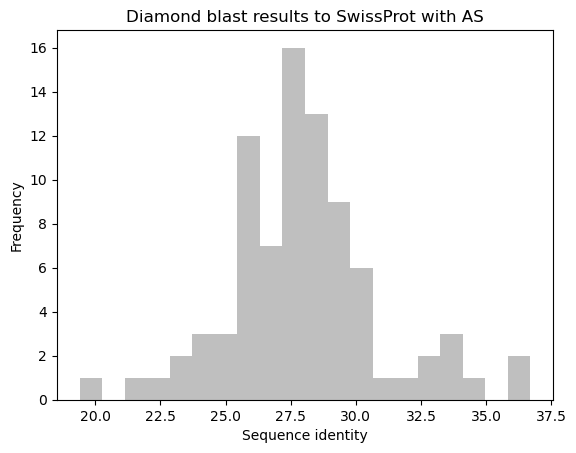

In [70]:
# Run this with BLAST residues
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(df, 'From', 'True_residues', 'BLAST_residues', 'Sequence')

rows = []
rows.append(['BLAST', None, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])
u.dp(['BLAST', '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])

plt.hist(df['sequence identity'].values, bins=20, color='grey', alpha=0.5)
plt.title('Diamond blast results to SwissProt with AS')
plt.ylabel('Frequency')
plt.xlabel('Sequence identity')

## Now run Squidly to predict the catalytic residues on the enzymes

Predict active sites with both the 3B and the 15B models.

In [71]:
# Run squidly
from enzymetk.predict_catalyticsite_step import ActiveSitePred
from enzymetk.save_step import Save
import pandas as pd
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'

# This should be where you downloaded the data from zotero, there is a folder in there called AS_inference
# This contains the models and the data needed to run the tool
squidly_dir = '/disk1/ariane/vscode/squidly/manuscript/CataloDB_models/'
num_threads = 1
id_col = 'Entry'
seq_col = 'Sequence'
test_df.reset_index(inplace=True)
squidly = (test_df << (ActiveSitePred(id_col, seq_col, squidly_dir, esm2_model = 'esm2_t36_3B_UR50D') >> Save('data/squidly_as_pred_3B.pkl')))


In [73]:
# Do the same with the 15B model
squidly_dir = '/disk1/ariane/vscode/squidly/manuscript/CataloDB_models/'
num_threads = 1
id_col = 'Entry'
seq_col = 'Sequence'
squidly = (test_df << (ActiveSitePred(id_col, seq_col, squidly_dir, esm2_model = 'esm2_t48_15B_UR50D') >> Save('data/squidly_as_pred_15B.pkl')))

# Check the results for the 15B and the 3B models

Here we join them with the test_df and make sure that we get similar results!

In [108]:

df = pd.read_csv(f'data/blast/cataloDB.csv')
df.set_index('Entry', inplace=True)
squidly = pd.read_pickle('data/squidly_as_pred_3B.pkl')
squidly.set_index('label', inplace=True)
df = df.join(squidly, how='left')

# Print out the predictions for the 3B
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(df, 'From', 'True_residues', 'Squidly_CR_Position', 'Sequence')
rows.append(['Squidly', '3B', f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])
u.dp(['Squidly 3B', '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])
rows = []
for squidly_cutoff in tqdm(range(0, 100, 2)):
    # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
    tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
    precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'chosen_residues', 'Sequence')
    rows.append(['3B', squidly_cutoff, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])


--------------------------------------------------------------------------------
Squidly 3B	
F1	0.6060000000000001	
precision:	0.5188356164383562	
 recall:	0.7283653846153846	
--------------------------------------------------------------------------------


100%|████████████████████████████████████████| 50/50 [00:02<00:00, 19.38it/s]


In [109]:
df = pd.read_csv(f'data/blast/cataloDB.csv')
df.set_index('Entry', inplace=True)
squidly = pd.read_pickle('data/squidly_as_pred_15B.pkl')
squidly.set_index('label', inplace=True)
df = df.join(squidly, how='left')

# Print out the predictions for the 3B
precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(df, 'From', 'True_residues', 'Squidly_CR_Position', 'Sequence')
#rows.append(['Squidly', '15B', f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])
u.dp(['Squidly 15B', '\nF1', f1, '\nprecision:', precision, '\n recall:', recall])

for squidly_cutoff in tqdm(range(0, 100, 2)):
    # 'From', 'True_residues', 'BLAST_residues', 'Sequence'
    tmp_df = ensemble_predictions(df, 'BLAST_residues', 'Squidly_CR_Position', 'sequence identity', squidly_cutoff)
    precision, recall, f1, support, agree, disagree, no_pred, mean_agreement = calculate_stats(tmp_df, 'From', 'True_residues', 'chosen_residues', 'Sequence')
    rows.append(['15B', squidly_cutoff, f1, precision, recall, support, agree, disagree, no_pred, mean_agreement])


--------------------------------------------------------------------------------
Squidly 15B	
F1	0.5987780040733198	
precision:	0.519434628975265	
 recall:	0.7067307692307693	
--------------------------------------------------------------------------------


100%|████████████████████████████████████████| 50/50 [00:02<00:00, 19.27it/s]


# Finally look at the ensemble of the two datasets

Here we want to look at ensembling 

In [110]:
def ensemble_predictions(df, blast_col, squidly_col, seq_id_col, squidly_similarity_cutoff=30):
    # Basically we update the choice of blast and squidly based on the cutoff 
    chosen_residues = []
    for blast_res, squidly_res, seq_id in df[[blast_col, squidly_col, seq_id_col]].values:
        # Also check if both are here otherwise pick the other one that was predicted
        if not isinstance(blast_res, str):
            chosen_residues.append(squidly_res)
        elif not isinstance(squidly_res, str):
            chosen_residues.append(blast_res)
        elif seq_id < squidly_similarity_cutoff:
            chosen_residues.append(squidly_res)
        elif seq_id >= squidly_similarity_cutoff:
            chosen_residues.append(blast_res)
        else:
            chosen_residues.append(None)
    df['chosen_residues'] = chosen_residues
    return df



In [111]:

vis_df = pd.DataFrame(rows, columns=['Dataset', '% cutoff', 'F1', 'Precision', 'Recall', 'Support', '% fully correct', ' % with difference', ' % missing', 'Mean correct'])
vis_df.to_csv('data/Ensemble_Squidly_CataloDB_15B.csv', index=False)

In [122]:
plt.rcParams['svg.fonttype'] = 'none'  # Ensure text is saved as text
plt.rcParams['figure.figsize'] = (3,3)
sns.set(rc={'figure.figsize': (3,3), 'font.family': 'sans-serif', 'font.sans-serif': 'Arial', 'font.size': 12}, 
        style='ticks')

def clean_plt(ax):
    ax.tick_params(direction='out', length=2, width=1.0)
    ax.spines['bottom'].set_linewidth(1.0)
    ax.spines['top'].set_linewidth(0)
    ax.spines['left'].set_linewidth(1.0)
    ax.spines['right'].set_linewidth(0)
    ax.tick_params(labelsize=10.0)
    ax.tick_params(axis='x', which='major', pad=2.0)
    ax.tick_params(axis='y', which='major', pad=2.0)
    return ax

    

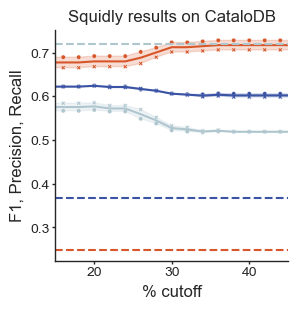

In [131]:
sns.color_palette(['#FFC440', '#D7572B', '#3A53A4', '#AFC6CF', '#895981', '#937A64'])
plt.rcParams['svg.fonttype'] = 'none'

# BLAST	
# F1	0.368515205724508	
# precision:	0.7202797202797203	
#  recall:	0.24759615384615385

# Squidly 3B	
# F1	0.6060000000000001	
# precision:	0.5188356164383562	
#  recall:	0.7283653846153846

# Squidly 15B	
# F1	0.5987780040733198	
# precision:	0.519434628975265	
#  recall:	0.7067307692307693	
ax.axvline(25, c='black', linestyle = 'dashed')
ax.axvline(45, c='black', linestyle = 'dashed')

ax = sns.lineplot(vis_df, x='% cutoff', y='Recall', legend=None, color='#D7572B') #palette=['#D7572B', '#D7572B', '#3A53A4', '#AFC6CF', '#895981', '#937A64'])
ax = sns.scatterplot(vis_df, x='% cutoff', y='Recall', style='Dataset', legend=None, markers=['o', 'X'], s=10, color='#D7572B') #palette=['#D7572B', '#D7572B', '#3A53A4', '#AFC6CF', '#895981', '#937A64'])
ax.axhline(0.24759615384615385, c='#D7572B', linestyle = 'dashed') # Recall for BLAST
#ax.axhline(0.7283653846153846, c='#D7572B') # Squidly 3B Recall
ax = sns.lineplot(vis_df, x='% cutoff', y='F1', ax = ax, legend=None, color='#3A53A4') # Blue is F1
ax = sns.scatterplot(vis_df, x='% cutoff', y='F1', ax = ax,  style='Dataset', legend=None, markers=['o', 'X'], s=10, color='#3A53A4') # Blue is F1
ax.axhline(0.368515205724508, c='#3A53A4', linestyle = 'dashed') # Blast F1
#ax.axhline(0.6060000000000001, c='#3A53A4') # Squidly 3B F1
ax = sns.lineplot(vis_df, x='% cutoff', y='Precision', legend=None, color='#AFC6CF') # light blue is precision
ax = sns.scatterplot(vis_df, x='% cutoff', y='Precision',  style='Dataset', legend=None, markers=['o', 'X'], s=10, color='#AFC6CF') # light blue is precision
ax.axhline(0.7202797202797203, c='#AFC6CF', linestyle='dashed') # BLAST Precision
#ax.axhline(0.5188356164383562, c='#AFC6CF') # Squidly Precision

plt.xlim(0, 100)
plt.xlim(15, 45)
clean_plt(plt.gca())
plt.title('Squidly results on CataloDB')
plt.ylabel('F1, Precision, Recall')
plt.savefig('figures/Recall_3B-15B_BLAST.svg')
plt.show()